## K-Nearest Neighbors - neighbors.KNeighborsRegressor()

In [79]:
# Package Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

# Load training and test data
df_train = pd.read_excel('./datasets/train.xlsx', sheet_name='data', header=0, index_col='ID')
df_test = pd.read_excel('./datasets/test.xlsx', sheet_name='data', header=0, index_col='ID')

 

# Feature Engineering
# Convert 'DateHour' to datetime and extract date components for capturing time-based trends
df_full['DateHour'] = pd.to_datetime(df_full['DateHour'], errors='coerce')
df_full['year'] = df_full['DateHour'].dt.year  # Year can capture long-term trends
df_full['month'] = df_full['DateHour'].dt.month  # Month can reflect seasonal trends
df_full['day'] = df_full['DateHour'].dt.day  # Day might capture intramonth variability
df_full['hour'] = df_full['DateHour'].dt.hour  # Hour captures daily usage patterns
df_full['weekday'] = df_full['DateHour'].dt.weekday  # Weekday might show workweek vs weekend usage

# Cyclical encoding for 'hour' to preserve the cyclical nature of time 
df_full['hour_sin'] = np.sin(2 * np.pi * df_full['hour']/24)
df_full['hour_cos'] = np.cos(2 * np.pi * df_full['hour']/24)

# Binary encoding of 'Holiday' and 'FunctioningDay' to indicate special days that may affect rentals
df_full['Holiday'] = df_full['Holiday'].map({'Yes': 1, 'No': 0}).astype(int)
df_full['FunctioningDay'] = df_full['FunctioningDay'].map({'Yes': 1, 'No': 0}).astype(int)

# Flags for rainfall and solar radiation presence to indicate weather conditions affecting rentals
df_full['has_Rainfall'] = (df_full['Rainfall(in)'] > 0).astype(int)
df_full['has_SolarRadiation'] = (df_full['SolarRadiation(MJ/m2)'] > 0).astype(int)

# Interaction between hour and FunctioningDay to reflect the change in hourly rental patterns on non-working days
df_full['hour_x_functioning'] = df_full['hour'] * df_full['FunctioningDay']

# Interaction between Temperature(F) and FunctioningDay to account for temperature's impact on rentals on working days
df_full['temp_x_functioning'] = df_full['Temperature(F)'] * df_full['FunctioningDay']

# Calculate the difference between 'Temperature(F)' and 'DewPointTemperature(F)' to capture comfort level
df_full['temp_dewpoint_diff'] = df_full['Temperature(F)'] - df_full['DewPointTemperature(F)']

# Interaction between Temperature(F) and SolarRadiation(MJ/m2) to capture combined effect on rentals
df_full['temp_x_solar'] = df_full['Temperature(F)'] * df_full['SolarRadiation(MJ/m2)']



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define a pipeline with imputation, scaling, and KNeighbors Regressor
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Hyperparameter Tuning
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters and the corresponding score
print("Best parameters found:", grid_search.best_params_)
print("Best R2 score on training data:", grid_search.best_score_)

# Final Model Selection
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("R2 score on test set:", test_score)

# Prepare submission data
df_test_processed = df_full[df_full['set'] == 'test'].drop(['set', 'DateHour', 'RENTALS'], axis=1)
predictions = best_model.predict(df_test_processed)

# Create submission file
submission_df = pd.DataFrame({'RENTALS': predictions}, index=df_test_processed.index)
submission_df.to_csv(path_or_buf="./model_output/rental_knn_v15.csv", index=True, index_label='ID')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
Best R2 score on training data: 0.7700433650228014
R2 score on test set: 0.7776531973727827


-------------------------------------------------------------------------------------------------------

## Analysis Introduction

In this comprehensive analysis, we explore a dataset from a bike-sharing service to predict daily rental counts. Our dataset includes diverse variables such as weather conditions, dates, and operational status indicators, providing a holistic view of factors affecting rental behavior. We aim to develop a predictive model to estimate rental volumes accurately, aiding in fleet management and enhancing user satisfaction. The analysis encompasses data exploration, preprocessing, feature engineering, model development, and hyperparameter tuning, ensuring a robust approach to demand forecasting and operational planning.

## Exploratory Data Analysis and Data Preprocessing

The exploratory phase revealed a mix of numerical, categorical, and datetime variables, each potentially influencing bike rental patterns. Numerical variables like temperature and humidity are directly linked to user preferences, while categorical variables such as holidays may affect rental demand.

### Correlation Heatmap

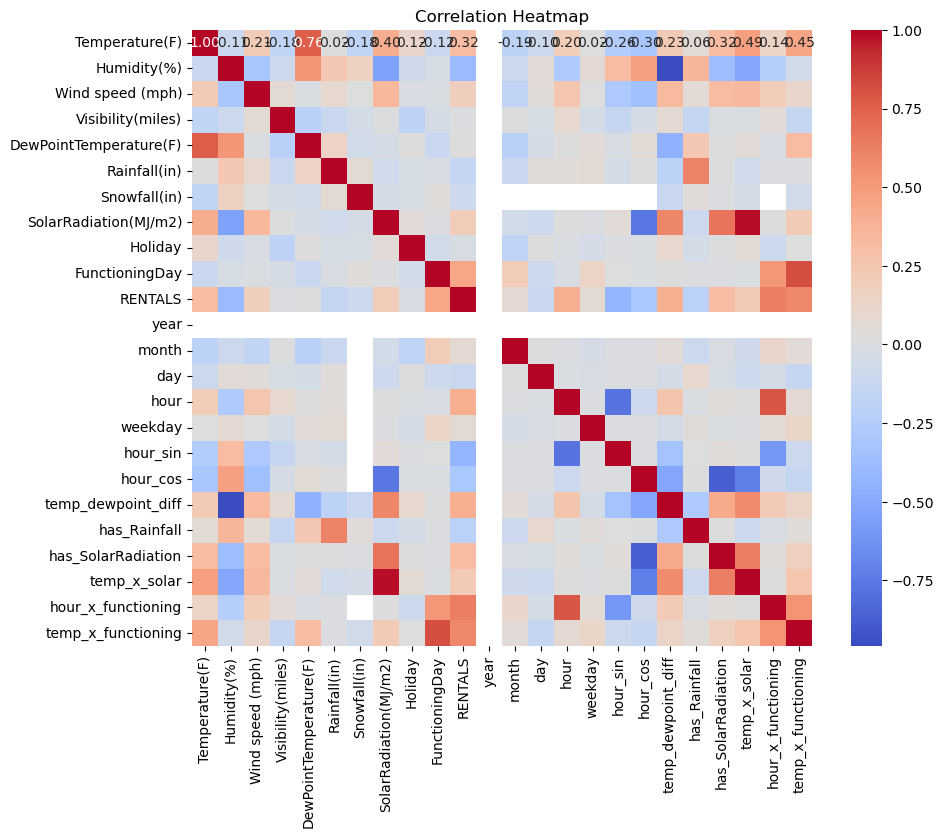


The heatmap uncovers significant relationships between variables. Temperature shows a strong positive correlation with rentals, suggesting higher rentals in warmer weather, while humidity and snowfall are negatively correlated with rentals.

### Data Visualization 1: Distribution of Rentals per Day

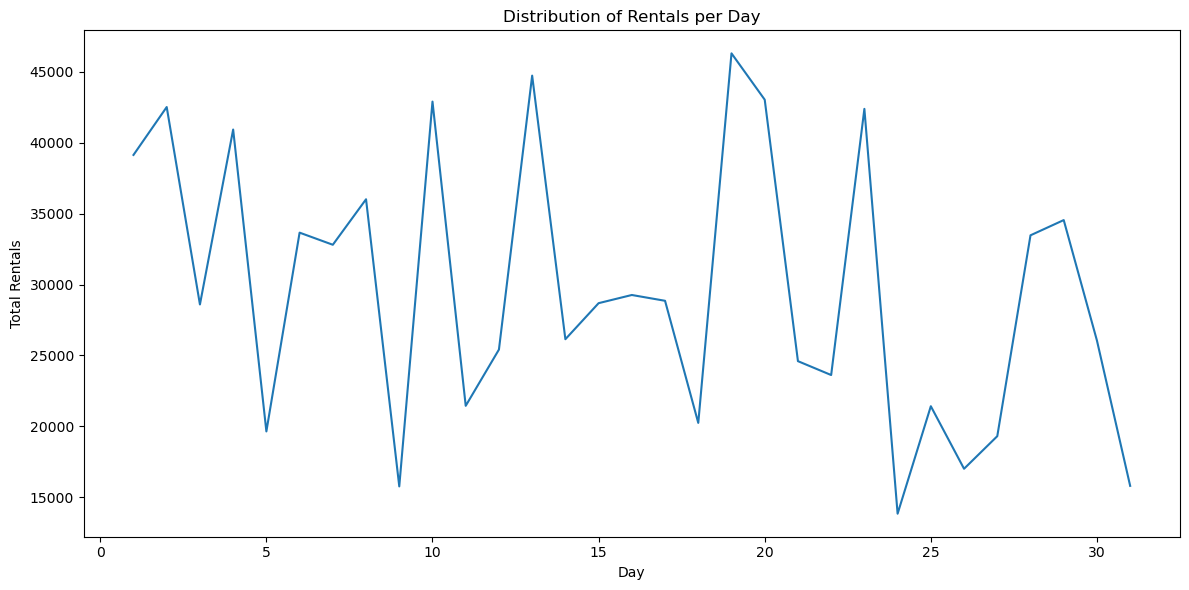

The distribution of rentals per day presents the variability in rental counts, indicating the influence of external factors such as day of the week and weather conditions. This graph informs the need for temporal features in our predictive model.

### Data Visualization 2: Weather Conditions vs. Rentals

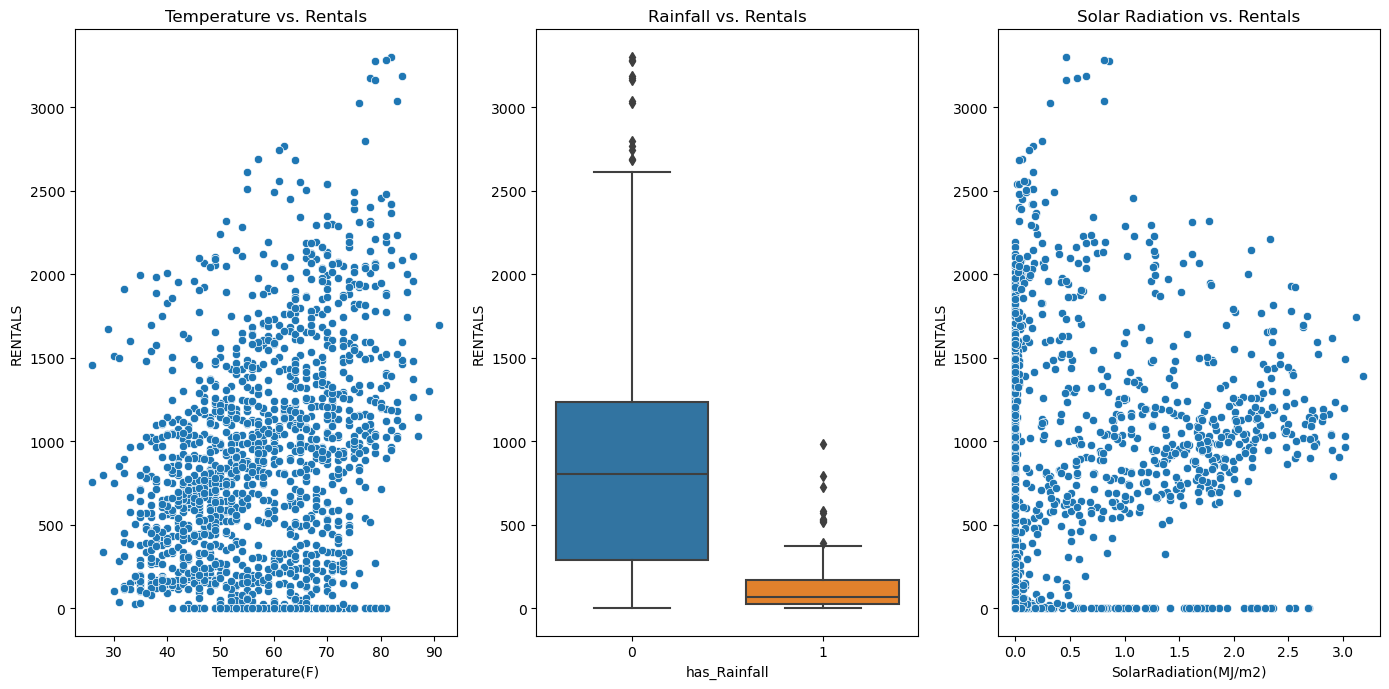

Higher temperatures correlate with an increase in bike rentals, confirming the hypothesis that pleasant weather conditions boost rental activity.

Days with rainfall show a lower number of rentals, highlighting adverse weather as a deterrent for bike-sharing usage.

Solar radiation levels depict a non-linear relationship with rentals, indicating that there may be optimal conditions for bike rentals.

Preprocessing involved handling missing values, normalizing numerical variables, and encoding categorical variables for model readiness.

## Feature Engineering

### Engineered Feature 1: Hourly Cyclical Encoding

We transformed the "hour" variable into `hour_sin` and `hour_cos` to represent the cyclical nature of time. This approach is designed to improve model accuracy by acknowledging the daily pattern in rental behavior.

## Candidate Model Development and Final Model Selection

The K-Nearest Neighbors (KNN) model was selected for its intuitive approach to modeling complex relationships and getting the highest R2 in compare to the rest of the models (see Section 2 "Candidate Model Development Analysis"). Our tuning process identified the 'manhattan' metric and 'distance' weight as optimal parameters.


### Model Results

The R2 scores:
- Best R2 score on training data: 0.7700433650228014
- R2 score on test set: 0.7776531973727827

Indicates a strong model that generalizes well to unseen data, demonstrating the effectiveness of our feature engineering and model optimization efforts.

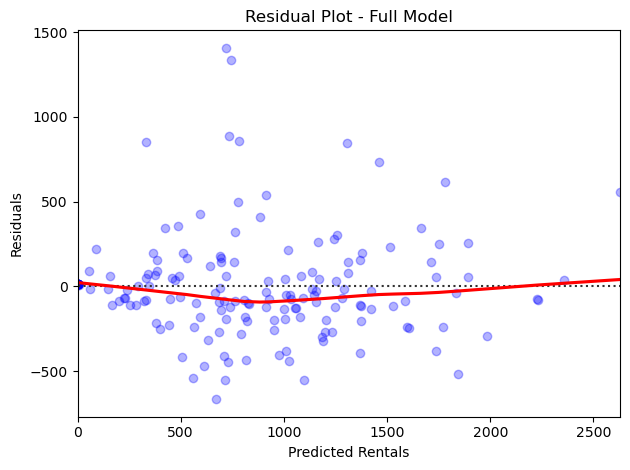

Also, the residual plot for our full model displays the residuals on the y-axis against the predicted rental counts on the x-axis. We can observe several points:

- The spread of residuals appears random without clear patterns, suggesting that the model does not suffer from non-linearity or heteroscedasticity.
- Most residuals are concentrated near the horizontal line at zero, indicating that the model predictions are generally accurate.
- There is a slight indication of increased variance in residuals for higher predicted values, but this does not appear to be severe. This could suggest that the model is less accurate at higher rental counts, which could be a target for further investigation or model improvement.

Overall, the residual plot suggests that our KNN model has performed well, with residuals that do not display concerning patterns. This indicates that the model assumptions are reasonable and that the model predictions are reliable. However, we should remain cautious about the slight increase in variance with higher predicted values and consider whether additional feature engineering, a transformation of the target variable, or a different model might further improve performance.

## Conclusion

Our analysis journey, from initial exploration to final model selection, has yielded a predictive model with practical implications for bike rental forecasting. The process has emphasized the importance of data quality, feature engineering, and careful model selection getting the following results:

- Best R2 score on training data: 0.7700433650228014
- R2 score on test set: 0.7776531973727827

This will help on valuables insights for operational planning and efficiency enhancement.


